In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Libraries**

In [43]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

Load and Transform Data

In [44]:
os.chdir("/content/drive/MyDrive/Computer vision/id_images")
!pwd

dataset = "/content/drive/MyDrive/Computer vision/id_images"


train_folder = '/content/drive/MyDrive/Computer vision/id_images/train/'
val_folder = '/content/drive/MyDrive/Computer vision/id_images/val/'
test_folder = '/content/drive/MyDrive/Computer vision/id_images/test/'

/content/drive/MyDrive/Computer vision/id_images


In [45]:
class_types = len(os.listdir(train_folder))
print('Number of classes for Classification: ',class_types)
class_names = os.listdir(train_folder)
print(f'The class names are {class_names}\n')

Number of classes for Classification:  10
The class names are ['srb_passport', 'alb_id', 'grc_passport', 'esp_id', 'aze_passport', 'svk_id', 'rus_internalpassport', 'est_id', 'fin_id', 'lva_passport']



Loading Data into a Dataframe

In [46]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths =  list(image_dir.glob(r'**/*.jpg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [47]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/Computer vision/id_imag...,esp_id
1,/content/drive/MyDrive/Computer vision/id_imag...,esp_id
2,/content/drive/MyDrive/Computer vision/id_imag...,esp_id
3,/content/drive/MyDrive/Computer vision/id_imag...,esp_id
4,/content/drive/MyDrive/Computer vision/id_imag...,esp_id
...,...,...
745,/content/drive/MyDrive/Computer vision/id_imag...,lva_passport
746,/content/drive/MyDrive/Computer vision/id_imag...,lva_passport
747,/content/drive/MyDrive/Computer vision/id_imag...,lva_passport
748,/content/drive/MyDrive/Computer vision/id_imag...,lva_passport


Data distribution

In [48]:
label_counts = image_df['Label'].value_counts()[:]
label_counts.size

10

<ipython-input-49-ea26467072fa>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='flare')


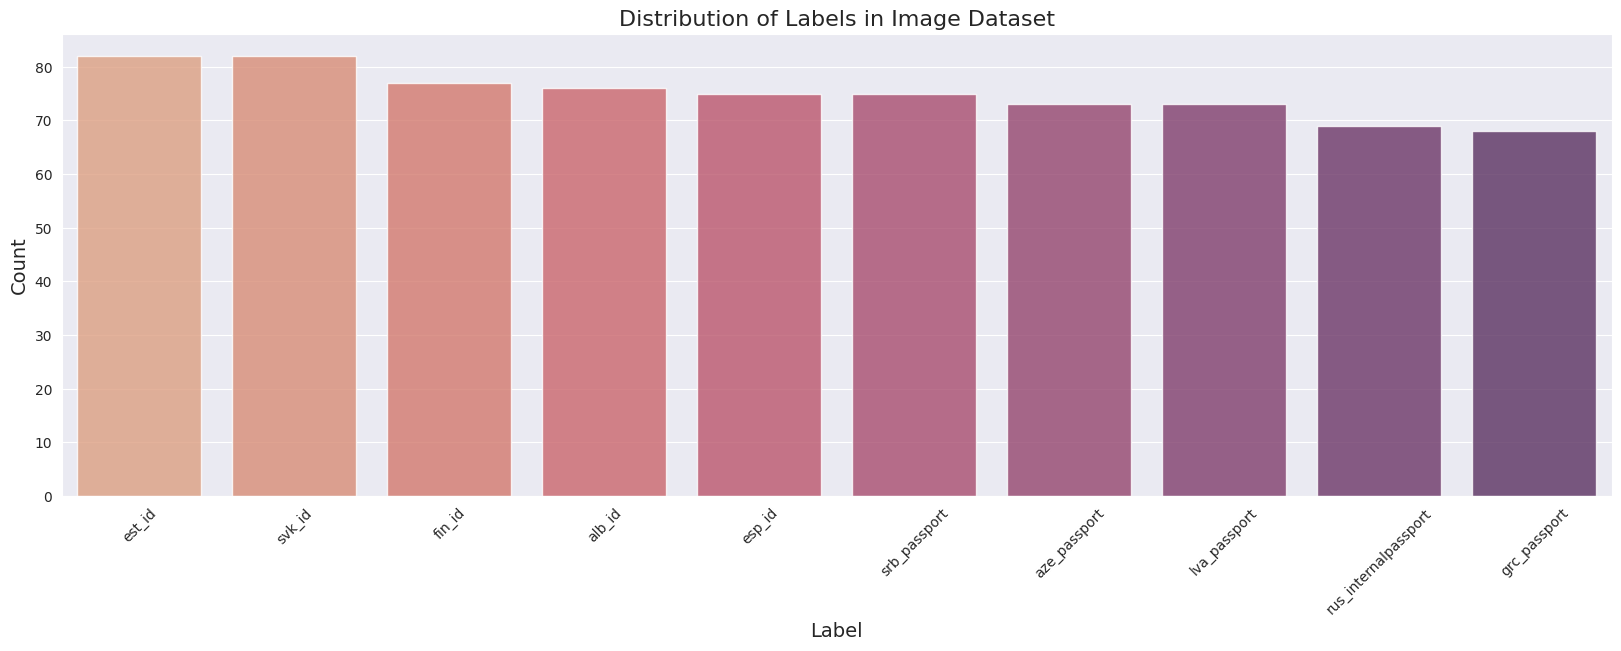

In [49]:


plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='flare')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()


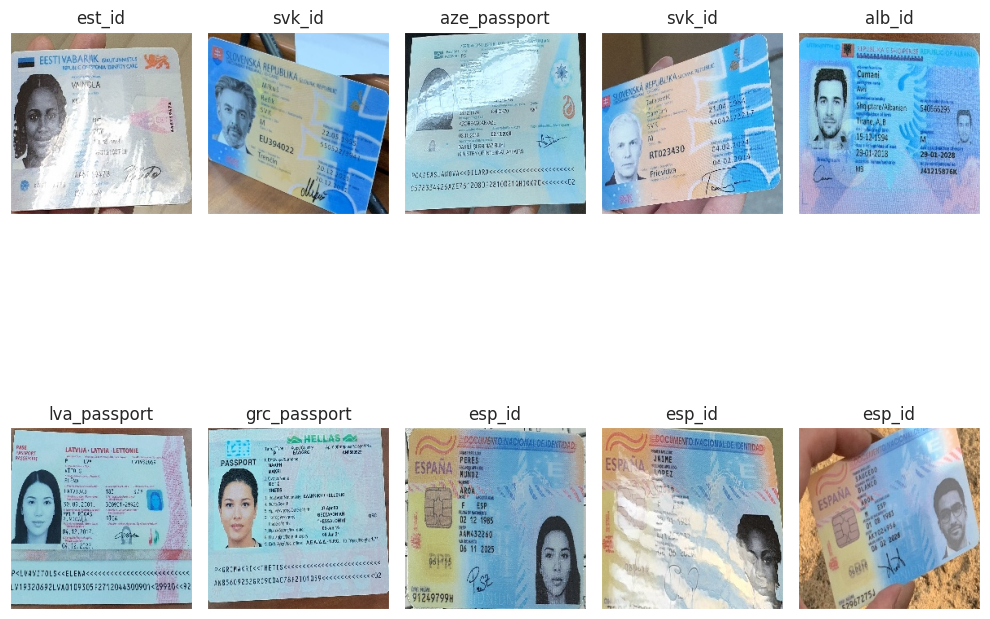

In [50]:
# Display 10 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 10)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

**Data Preprocessing**

In [51]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

The data will be split into three different categories: Training, Validation and Testing.

In [52]:
def preprocess_input(image):
    # Rescale pixel values to the range of [0, 1]
    image /= 255.0
    return image

In [53]:
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [54]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [55]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 480 validated image filenames belonging to 10 classes.
Found 120 validated image filenames belonging to 10 classes.
Found 150 validated image filenames belonging to 10 classes.


**Create model and train**

Simplest CNN

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [57]:
# Define the input shape
input_shape = (225, 225, 3)
num_classes = 10

# Initialize the CNN
model = Sequential()

# Add first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))

# Add first pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add second pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # For multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 223, 223, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 186624)            0         
                                                                 
 dense_13 (Dense)            (None, 128)              

Compile and train the model

In [58]:
# Create checkpoint callback
checkpoint_path = "id_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [59]:
history = model.fit(train_images,
                    validation_data = val_images,
                    callbacks=[
                      early_stopping,
                      checkpoint_callback,
                      reduce_lr
                    ],
                    verbose=0,
                    epochs=50  # Training for n_epoch interations
                   )


In [68]:
model.save("/content/drive/MyDrive/Computer vision/id_classifier_simple_cnn" + str(int(results[1]) * 100) + ".keras")  # The file needs to end with the .keras extension

In [60]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.17262
Test Accuracy: 97.33%


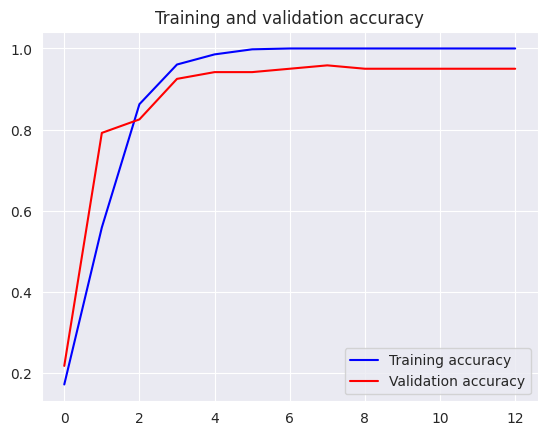

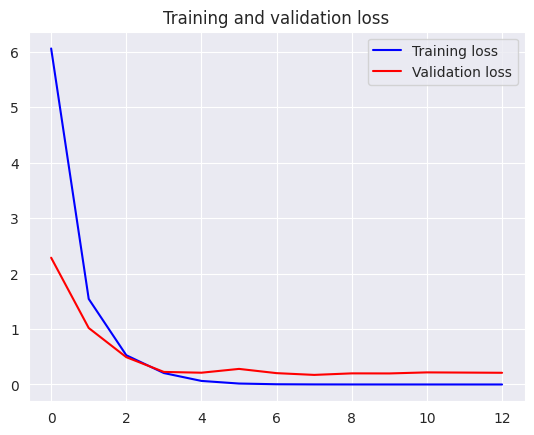

In [61]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [64]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

5/5 [==============================] - 4s 707ms/step


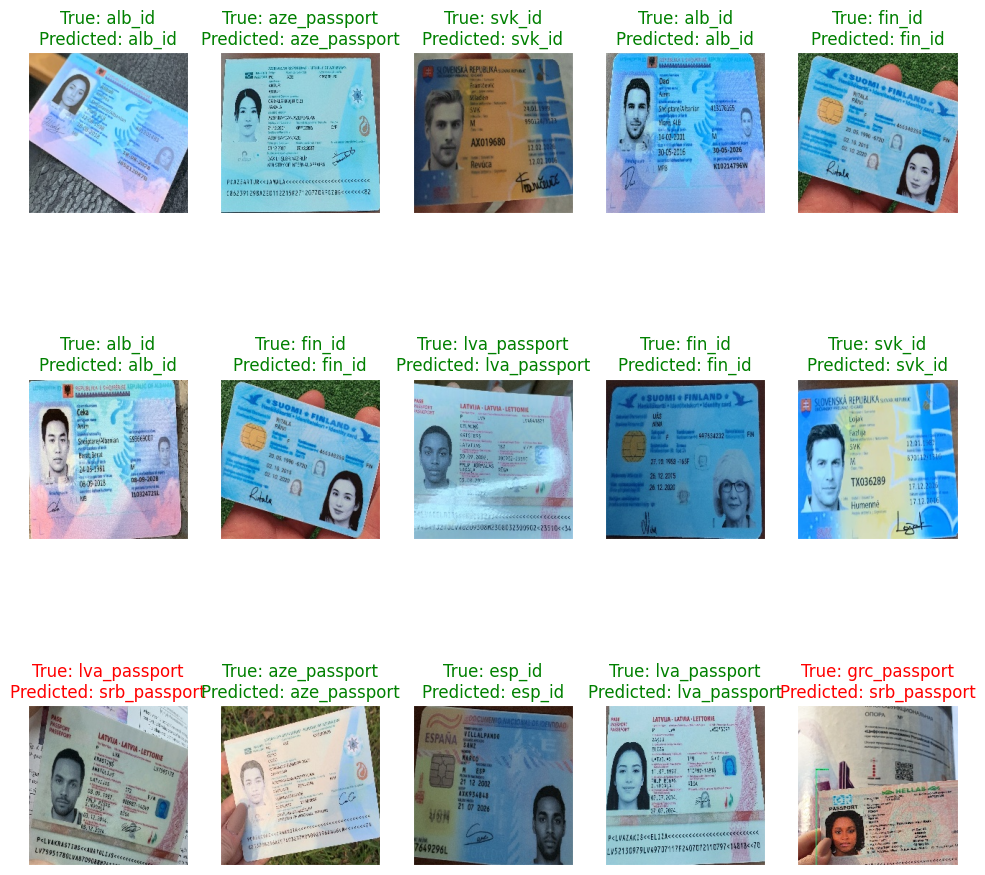

<Figure size 640x480 with 0 Axes>

In [67]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [65]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                      precision    recall  f1-score   support

              alb_id       1.00      1.00      1.00        19
        aze_passport       0.94      1.00      0.97        16
              esp_id       1.00      1.00      1.00        14
              est_id       1.00      1.00      1.00        14
              fin_id       1.00      1.00      1.00        10
        grc_passport       1.00      0.84      0.91        19
        lva_passport       1.00      0.92      0.96        12
rus_internalpassport       1.00      1.00      1.00        19
        srb_passport       0.80      1.00      0.89        12
              svk_id       1.00      1.00      1.00        15

            accuracy                           0.97       150
           macro avg       0.97      0.98      0.97       150
        weighted avg       0.98      0.97      0.97       150

